## Sagnac Frequency - Backscatter Correction - RV Backscatter

Explore the longterm behaviour of the RV sagnac beat

## Imports

In [126]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [127]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [128]:
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

## Configurations

In [130]:
config = {}

config['ring'] = "V"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"


config['tbeg'] = UTCDateTime("2024-05-22 16:00")
config['tend'] = UTCDateTime("2024-06-07 00:00")

flim1, flim2 = 447.726, 447.736



## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

## Configurations

In [131]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

### Compute Backscatter (again)

In [132]:
from functions.backscatter_correction import __backscatter_correction

In [133]:
# unwrap phases as one time series
bs['fj_ph'] = np.unwrap(bs.fj_ph)
bs['f1_ph'] = np.unwrap(bs.f1_ph)
bs['f2_ph'] = np.unwrap(bs.f2_ph)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# beat signal observed
w_obs = bs.fj_fs

# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs.fj_fs), cm_filter_factor=1.033)

(447.726, 447.736)

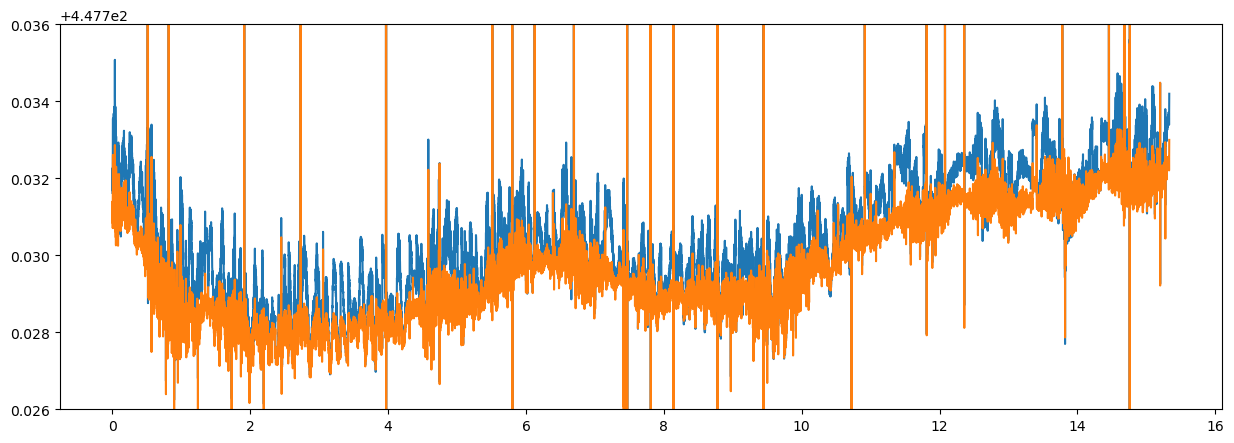

In [134]:
plt.figure(figsize=(15, 5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.plot(bs.time_sec/86400, bs.fj_bs)

# plt.plot(bs.time_sec/86400, gaussian_filter1d(bs.fj_bs, 2))

plt.ylim(flim1, flim2)

### Cut corrupt data periods

In [135]:
# times = [("2023-12-04T09:11", "2023-12-04T18:01")]

# for t1, t2 in times:
#     bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
#     bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_bs)


# bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
# bs['fj_bs'] = np.nan_to_num(bs['fj_bs'], nan=np.nanmedian(bs['fj_bs']))

In [136]:
from functions.load_mlti import __load_mlti

mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

In [137]:
from functions.get_mlti_intervals import __get_mlti_intervals

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

In [164]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=300)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=300)

### Apply special filter sections

In [165]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [175]:
from functions.smoothing import __smooth

n_minutes = 60

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

### Load LXX maintenance

In [167]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [168]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

In [169]:
bs

,index,time1,time2,fj_fs,fj_ac,fj_dc,fj_ph,f1_fs,f1_ac,f1_dc,...,bscorrection,term,time_sec,fj_bs,fj_fs_nan,fj_bs_nan,fj_fs_inter,fj_bs_inter,fj_fs_smooth,fj_bs_smooth
0,0,2024-05-22T16:00:00.000000Z,2024-05-22T16:01:00.000000Z,447.731621,0.437375,0.413327,0.789380,447.744928,0.002458,0.806722,...,0.000890,0.999998,60.0,447.730730,447.731621,447.730730,447.731621,447.730730,NaN,NaN
1,1,2024-05-22T16:01:00.000000Z,2024-05-22T16:02:00.000000Z,447.732264,0.437378,0.413307,0.327043,447.743821,0.002448,0.806753,...,0.000868,0.999998,120.0,447.731395,447.732264,447.731395,447.732264,447.731395,NaN,NaN
2,2,2024-05-22T16:02:00.000000Z,2024-05-22T16:03:00.000000Z,447.731945,0.437177,0.413321,-0.123636,447.738351,0.002449,0.806844,...,0.000858,0.999998,180.0,447.731087,447.731945,447.731087,447.731945,447.731087,NaN,NaN
3,3,2024-05-22T16:03:00.000000Z,2024-05-22T16:04:00.000000Z,447.732086,0.437248,0.413312,-0.582421,447.745456,0.002455,0.806858,...,0.000854,0.999998,240.0,447.731232,447.732086,447.731232,447.732086,447.731232,NaN,NaN
4,4,2024-05-22T16:04:00.000000Z,2024-05-22T16:05:00.000000Z,447.732158,0.437125,0.413301,-1.035670,447.740769,0.002464,0.806892,...,0.000850,0.999998,300.0,447.731308,447.732158,447.731308,447.732158,447.731308,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22075,55,2024-06-06T23:55:00.000000Z,2024-06-06T23:56:00.000000Z,447.733388,0.344392,0.368604,-24471.197880,447.733772,0.002171,0.735285,...,0.001183,0.999997,1324560.0,447.732204,447.733388,447.732204,447.733388,447.732204,NaN,NaN
22076,56,2024-06-06T23:56:00.000000Z,2024-06-06T23:57:00.000000Z,447.733766,0.341854,0.368592,-24471.057734,447.733854,0.002170,0.735234,...,0.001181,0.999997,1324620.0,447.732585,447.733766,447.732585,447.733766,447.732585,NaN,NaN
22077,57,2024-06-06T23:57:00.000000Z,2024-06-06T23:58:00.000000Z,447.733681,0.342786,0.368638,-24470.898944,447.734445,0.002181,0.735267,...,0.001189,0.999997,1324680.0,447.732491,447.733681,447.732491,447.733681,447.732491,NaN,NaN
22078,58,2024-06-06T23:58:00.000000Z,2024-06-06T23:59:00.000000Z,447.733666,0.343245,0.368638,-24470.761861,447.734135,0.002194,0.735259,...,0.001197,0.999997,1324740.0,447.732468,447.733666,447.732468,447.733666,447.732468,NaN,NaN


### Checkup Plot

/tmp/ipykernel_166625/1830721788.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


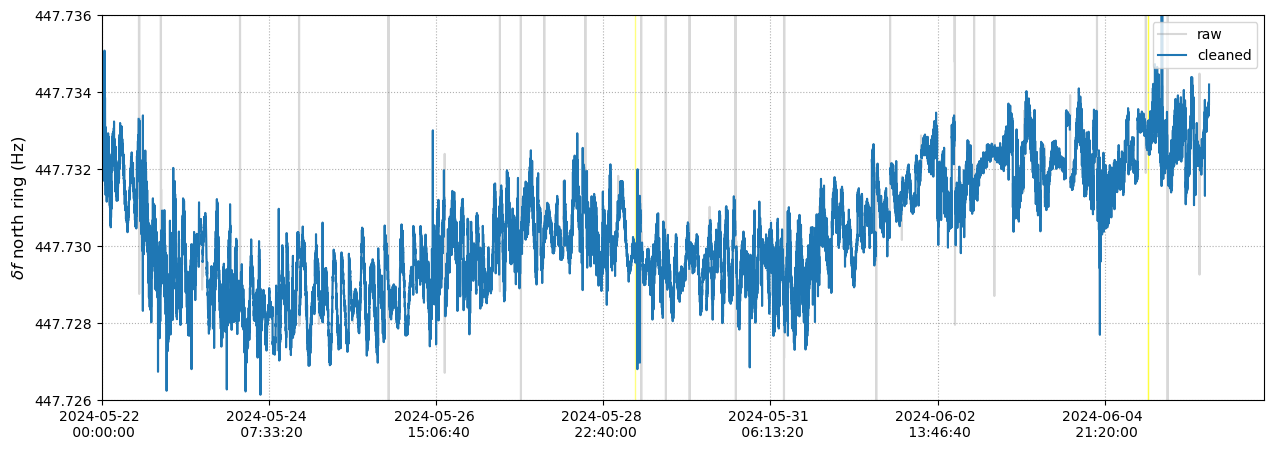

In [170]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring'}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


In [171]:
from functions.multitaper_psd import __multitaper_psd
from scipy.signal import detrend

dat1 = detrend(bs.fj_fs_inter, type="linear")
dat2 = detrend(bs.fj_bs_inter, type="linear")

# f1, psd1 = __multitaper_psd(dat1, 60, n_win=10, time_bandwidth=3.5)
# f2, psd2 = __multitaper_psd(dat2, 60, n_win=10, time_bandwidth=3.5)

# f1, psd1 = __welch_psd(dat1, 60, twin_sec=86400)
# f2, psd2 = __welch_psd(dat2, 60, twin_sec=86400)

psd1, f1, pha1 = __get_fft(dat1, 60)
psd2, f2, pha2 = __get_fft(dat2, 60)


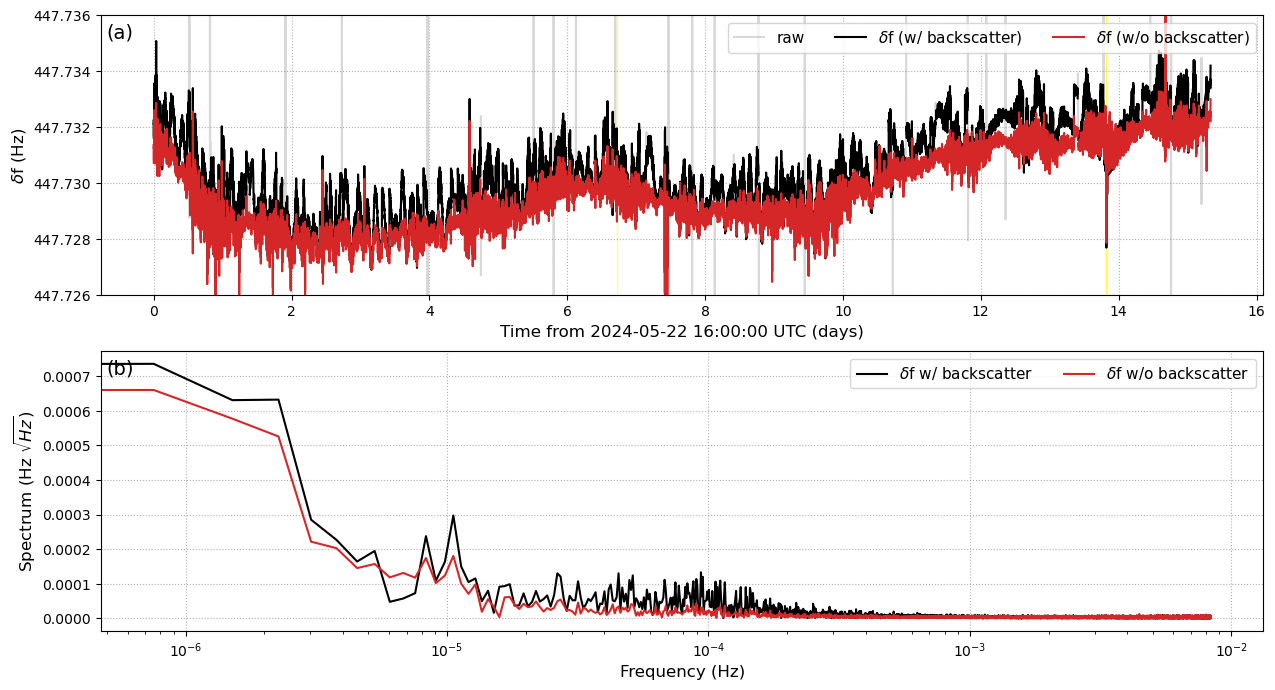

In [174]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    tscale, tunit = 1/86400, "days"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax[0].plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")

    ax[0].ticklabel_format(useOffset=False)

    ax[1].semilogx(f1, psd1, color="black", label=f"$\delta$f w/ backscatter")
    ax[1].semilogx(f2, psd2, color="tab:red", label=f"$\delta$f w/o backscatter")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, fontsize=font-1, ncol=3)

    ax[0].set_ylim(flim1, flim2)


    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC ({tunit})", fontsize=font)

    # ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)
    ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)

    # ax[1].axvline(1/(6*3600), ls="--", color="grey", zorder=0)
    # ax[1].axvline(1/(14*3600), ls="--", color="grey", zorder=0)

    ax[0].text(.005, .97, "(a)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.005, .97, "(b)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax[0].fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_spectrum_{config['tbeg']}_{config['tend']}.png", format="png", dpi=200, bbox_inches='tight')


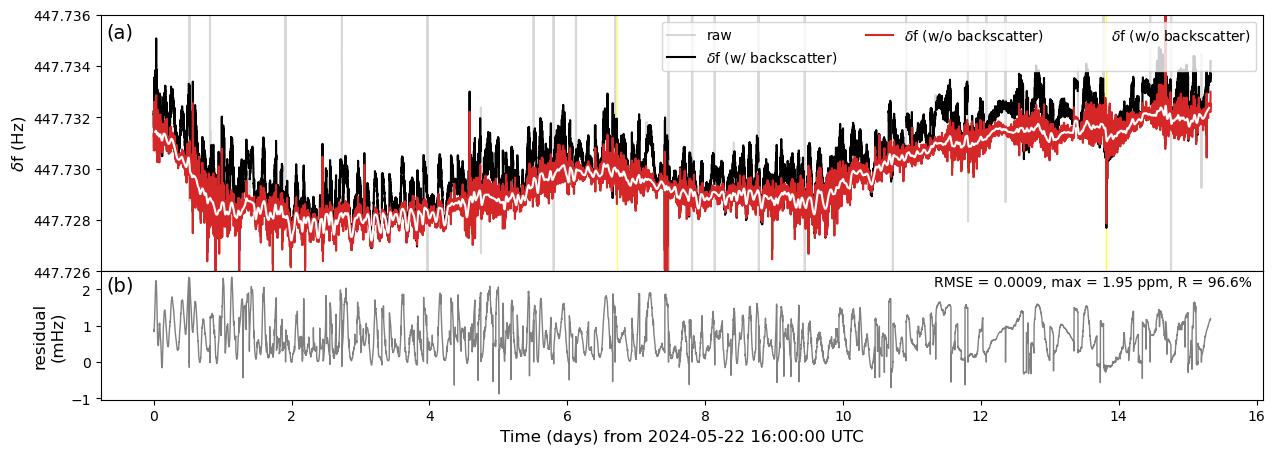

In [176]:
def __makeplot_residual():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.to_dB import __to_dB
    from functions.variance_reduction import __variance_reduction


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __get_residual_percent(dat1, dat2):
        imax, vmax = np.argmax(abs(dat2-dat1)), np.amax(abs(dat2-dat1))
        pmax = round(np.amax(dat2-dat1)/dat1[imax]*1e6, 2)
        return pmax

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)



    tscale, tunit = 1/86400, "days"


    Ncol, Nrow = 1, 3

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 5))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])

    ax1.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax1.plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", label=f"$\delta$f (w/o backscatter)")

    ax2.plot(bs.time_sec*tscale, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", lw=lw)
    # ax2.fill_between(bs.time_sec*tscale, 0, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", alpha=0.3)

    ax1.set_ylim(flim1, flim2)
    ax1.ticklabel_format(useOffset=False)
    ax1.legend(loc=1, ncol=3)

    ax1.set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax2.set_ylabel(f"residual\n(mHz)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    R = __variance_reduction(bs.fj_fs, bs.fj_fs - bs.fj_bs)

    txt = f"RMSE = {__rmse(bs.fj_fs, bs.fj_bs)}, max = {__get_residual_percent(bs.fj_fs, bs.fj_bs)} ppm, R = {R}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    # ax1.set_title(f"{til_in[0].stats.station} & {acc_in[0].stats.station} | f = {fmin} - {fmax} Hz")

    # ax1.grid(ls=":", zorder=0)
    # ax2.grid(ls=":", zorder=0)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax1.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.plot();
    return fig

fig = __makeplot_residual()

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_residual_{config['tbeg']}_{config['tend']}.png", format="png", dpi=200, bbox_inches='tight')


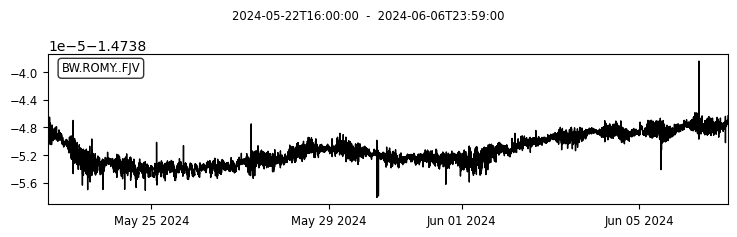

In [559]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

dff = np.array(bs.fj_bs_inter)

dff_tilt = __sagnac_to_tilt(dff, config['ring'])

rx = Trace()
rx.data = dff_tilt
rx.stats.delta = 60
rx.stats.starttime = bs.time1.iloc[0]
rx.stats.station = "ROMY"
rx.stats.channel = f"FJ{config['ring']}"
rx.stats.network = "BW"

rx = Stream(rx)

rx.plot();

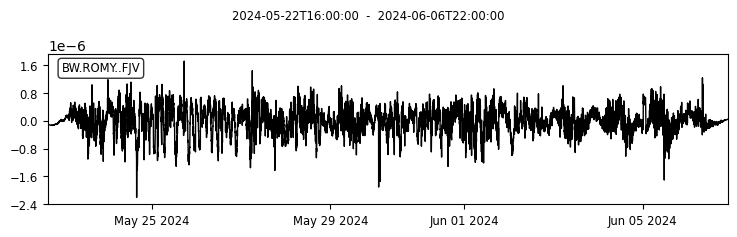

In [578]:
fmin, fmax = 1/(30*3600), 1/(0.1*3600)


rxx = rx.copy()

rxx = rxx.trim(config['tbeg'], config['tend'], nearest_sample=False)
rxx = rxx.detrend("linear")
rxx = rxx.taper(0.1)
rxx = rxx.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
rxx = rxx.resample(10*fmax, no_filter=True)
rxx = rxx.trim(config['tbeg'], config['tend']-7200, nearest_sample=True)

rxx

rxx.plot();

5 Trace(s) in Stream:
BW.ALFT..LDO | 2024-05-22T16:00:00.000000Z - 2024-06-07T00:00:00.000000Z | 1.0 Hz, 1324801 samples
BW.TON..LDO  | 2024-05-22T16:00:00.000000Z - 2024-06-07T00:00:00.000000Z | 1.0 Hz, 1324801 samples
BW.BIB..LDO  | 2024-05-22T16:00:00.000000Z - 2024-06-07T00:00:00.000000Z | 1.0 Hz, 1324801 samples
BW.GELB..LDO | 2024-05-22T16:00:00.000000Z - 2024-06-07T00:00:00.000000Z | 1.0 Hz, 1324801 samples
BW.GRMB..LDO | 2024-05-22T16:00:00.000000Z - 2024-06-07T00:00:00.000000Z | 1.0 Hz, 1324801 samples
-58 0.9347307883962113
41 0.952205697306233
23 0.9439968246976382
41 0.9799092475865344


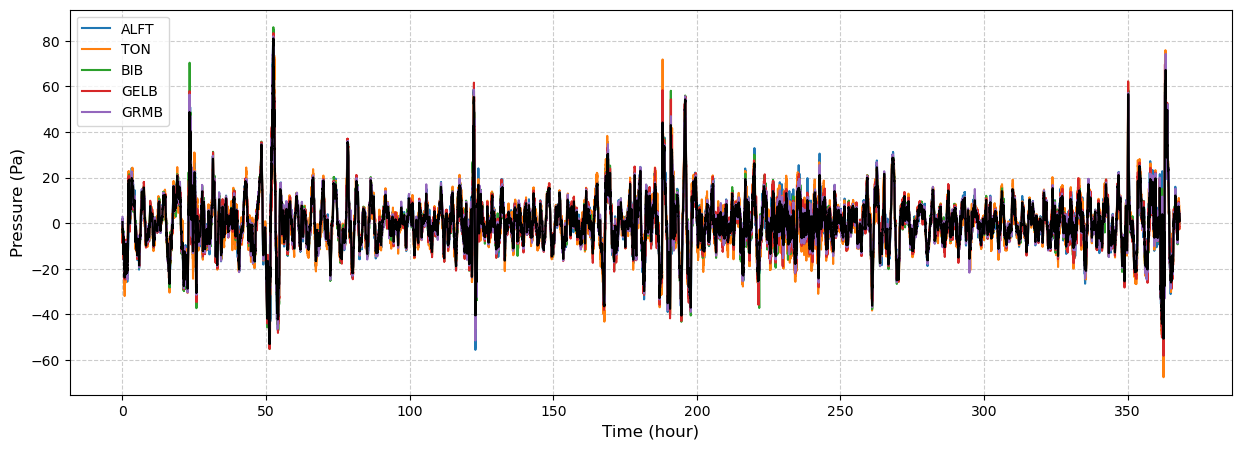

In [549]:
def __get_mean_rmy_pressure(stations, t1, t2, path_to_data, plot=False):

    import matplotlib.pyplot as plt
    from andbro__read_sds import __read_sds
    from obspy import Stream
    from functions.interpolate_nan import __interpolate_nan
    from functions.smoothing import __smooth
    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import arange, roll, array

    ps0 = Stream()

    for jj in stations:
        if jj == "PROMY":
            loc, cha = "03", "LDI"
        else:
            loc, cha = "", "LDO"

        ps0 += __read_sds(path_to_data+"temp_archive/", f"BW.{jj}.{loc}.{cha}", t1-10, t2+10)

    ps0 = ps0.trim(t1, t2)

    # update stations
    stations = []
    for tr in ps0:
        stations.append(tr.stats.station)

        # smooth data
        tr.data = __smooth(tr.data, 30)

    # convert from hPa to Pa
    for tr in ps0:
        if "03" in tr.stats.location:
            tr.data = __interpolate_nan(tr.data)
        else:
            tr.data = tr.data * 100 # scale to Pa
            tr.data = __interpolate_nan(tr.data)

    # equalize number of samples
    npts_min = ps0[0].stats.npts
    for tr in ps0:
        if tr.stats.npts < npts_min:
            npts_min
    for tr in ps0:
        diff = abs(tr.stats.npts - npts_min)
        if diff != 0:
            tr.data = tr.data[:-diff]

    print(ps0)

    ps0 = ps0.detrend("linear")
    ps0 = ps0.detrend("simple")
    ps0 = ps0.filter("highpass", freq=1/(6*3600), corners=4, zerophase=True);

    # shift traces to compute mean of array
    shifted = []

    for i, sta in enumerate(stations):

        if i == 0:
            arr0 = ps0.select(station=sta)[0].data
            shifted.append(arr0)
            continue
        else:
            arr1 = ps0.select(station=sta)[0].data

        Nshift = len(arr0)

        dt = ps0[0].stats.delta

        ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')

        cclags = arange(-Nshift, Nshift+1) * dt

        shift1, value1 = xcorr_max(ccf1)
        print(shift1, value1)

        arr1_shifted = roll(arr1, shift1)

        shifted.append(arr1_shifted)

        # compute mean
        _mean = array([])
        for i, arr in enumerate(shifted):
            if i == 0:
                _mean = arr
            else:
                _mean = _mean + arr

    mean = ps0[0].copy()
    mean.stats.station = "RMY"
    mean.stats.location = "00"
    mean.stats.channel = "LDO"
    mean.data = _mean/(i+1)

    # checkup plot
    if plot:
        times = ps0[0].times()/3600
        plt.figure(figsize=(15, 5))
        for i, x in enumerate(shifted):
            plt.plot(times, x, label=stations[i], zorder=2)
        plt.plot(times, mean.data, "k", zorder=2)
        plt.legend()
        plt.grid(ls="--", color="grey", alpha=0.4)
        plt.ylabel("Pressure (Pa)", fontsize=12)
        plt.xlabel("Time (hour)", fontsize=12)
        plt.show();

    return mean

rmy = __get_mean_rmy_pressure(["PROMY", "ALFT", "TON", "BIB", "GELB", "GRMB"],
                              config['tbeg'], config['tend'],
                              archive_path,
                              plot=True,
                             )

In [550]:
def __get_tides(tbeg, tend, component="N", typ="acc", df=3600):

    from pygtide import predict_series
    from numpy import arange, pi
    from obspy import UTCDateTime

    # ROMY
    lat = 48.162941
    lon = 11.275501
    height = 570

    startdate = str(UTCDateTime(tbeg).date)
    duration =  (UTCDateTime(tend) -  UTCDateTime(tbeg)) /3600 # in hours
    sampling_rate = df # in seconds

    # creat time vector
    times = arange(0, duration+df/3600, df/3600)

    # prepare arguments
    args = (lat, lon, height, startdate, duration, sampling_rate)

    # specify station azimuth clockwise from north (=0)
    if component == "N":
        statazimut = 0
    elif component == "E":
        statazimut = 90



    if typ == "rad":
        # tides /= 9.81
        tides = predict_series(*args, statgravit=0, statazimut=statazimut, tidalcompo=1) # tilt

        # from mas to rad
        tides = tides * pi / 648000000

    elif typ == "acc":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=0) # horizontal acceleration

        # from nano to acc
        tides *= 1e-9

    elif typ == "str":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=5) # horizontal strain

        # from nano to str
        tides *= 1e9

    return times, tides

In [551]:
# predict tidal tilts
times, tideN = __get_tides(config['tbeg'], config['tend']-1, component="N", typ="rad", df=3600)
times, tideE = __get_tides(config['tbeg'], config['tend']-1, component="E", typ="rad", df=3600)


In [552]:
gtide = Stream()

gtideN = Trace()
gtideN.data = tideN
gtideN.stats.delta = 3600
gtideN.stats.starttime = config['tbeg']
gtideN.stats.station = "GTID"
gtideN.stats.channel = "LAN"
gtideN.stats.network = "BW"

gtideE = Trace()
gtideE.data = tideE
gtideE.stats.delta = 3600
gtideE.stats.starttime = config['tbeg']
gtideE.stats.station = "GTID"
gtideE.stats.channel = "LAE"
gtideE.stats.network = "BW"

gtide += gtideE
gtide += gtideN

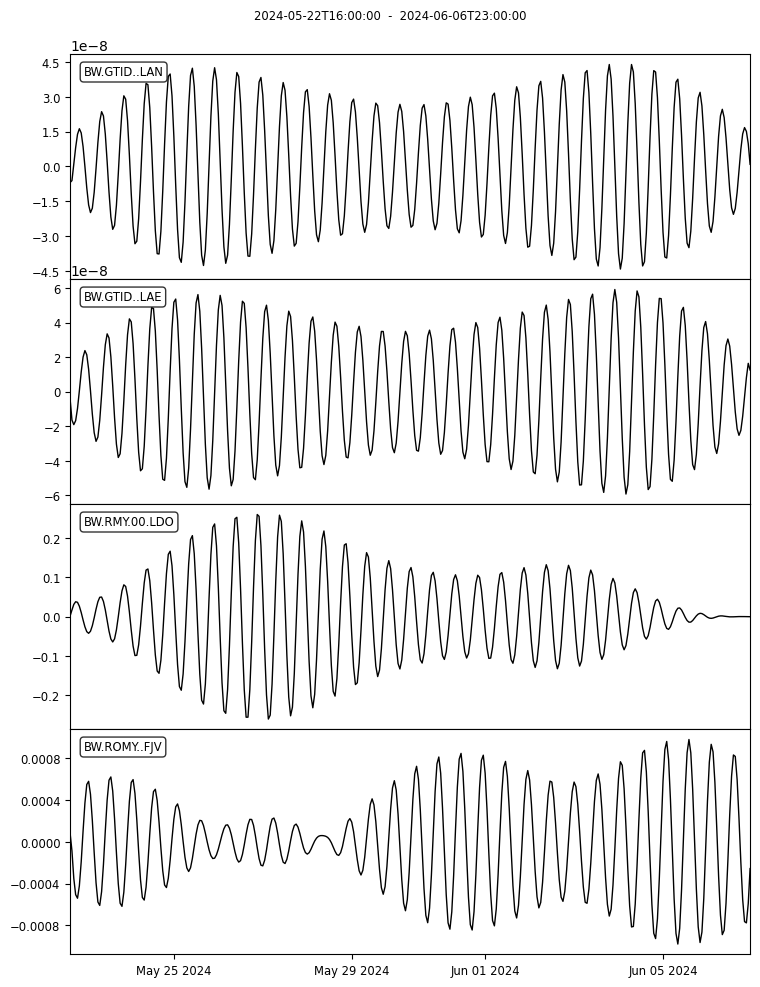

In [620]:
fmin, fmax = 1/(13*3600), 1/(11*3600)


stt = Stream()

stt += rx.copy().integrate()
stt += gtide.copy()
stt += rmy.copy()

stt = stt.trim(config['tbeg'], config['tend'], nearest_sample=False)

stt = stt.detrend("demean")
stt = stt.detrend("linear")

stt = stt.taper(0.1, type="cosine")

NN = 10000
for tr in stt:
    tr.data = np.pad(tr.data, (NN, NN), 'constant')

stt = stt.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

for tr in stt:
    tr.data = tr.data[NN:-NN]

stt = stt.resample(1/3600, no_filter=True)

# stt = stt.trim(config['tbeg'], config['tend']-7200, nearest_sample=True)

stt.plot(equal_scale=False);

In [621]:
def __estimate_linear_coefficients(st0, c1="V", c2="N", c3="E"):

    from scipy.signal import hilbert
    from numpy import imag, array, linalg, vstack


    # data1
    pp = st0.select(channel=c2)[0].data

    # data2
    hp = st0.select(channel=c3)[0].data

    # data
    dd = st0.select(channel=c1)[0].data

    # matrix
    A = vstack([pp, hp]).T

    # least squares
    a, b = linalg.lstsq(A, dd, rcond=None)[0]

    # estimate of data
    hh = a*pp + b*hp

    # residual
    rr = dd - hh

    return a, b, hh, rr

In [622]:
def __estimate_linear_coefficients_pressure(st0, c1="N", c2="O", c3=None):

    from scipy.signal import hilbert
    from numpy import imag, array, linalg, vstack

    if c3 is None:
        c3 = c2

    # pressure
    pp = st0.select(channel=c2)[0].data

    # hilbert(pressure)
    hp = imag(hilbert(st0.select(channel=c3)[0].data))

    # data
    dd = st0.select(channel=c1)[0].data

    # matrix
    A = vstack([pp, hp]).T

    # least squares
    a, b = linalg.lstsq(A, dd, rcond=None)[0]

    # estimate of data
    hh = a*pp + b*hp

    # residual
    rr = dd - hh

    return a, b, hh, rr

-12807.89839828689 -2237.7424225104164


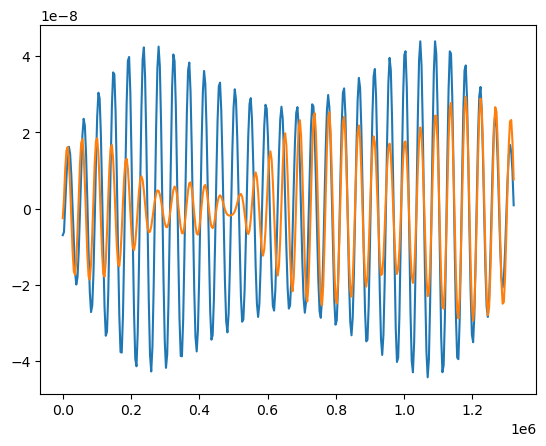

In [623]:
t0, dat0 = stt.select(component="E")[0].times(reftime=config['tbeg']), stt.select(component="E")[0].data
t1, dat1 = stt.select(component="N")[0].times(reftime=config['tbeg']), stt.select(component="N")[0].data

t2, dat2 = stt.select(component="V")[0].times(reftime=config['tbeg']), stt.select(component="V")[0].data

t3, dat3 = stt.select(component="O")[0].times(reftime=config['tbeg']), stt.select(component="O")[0].data

dat2_mod = dat2 * -3e-5

a_p, b_p, mod_p, res_p = __estimate_linear_coefficients_pressure(stt, c1="FJV", c2="LDO", c3="LDO")

stt.select(component="V")[0].data = res_p

a, b, mod, res = __estimate_linear_coefficients(stt, c1="FJV", c2="LAN", c3="LAE")


plt.plot(t1, dat1)

plt.plot(t2, dat2_mod)

print(a, b)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


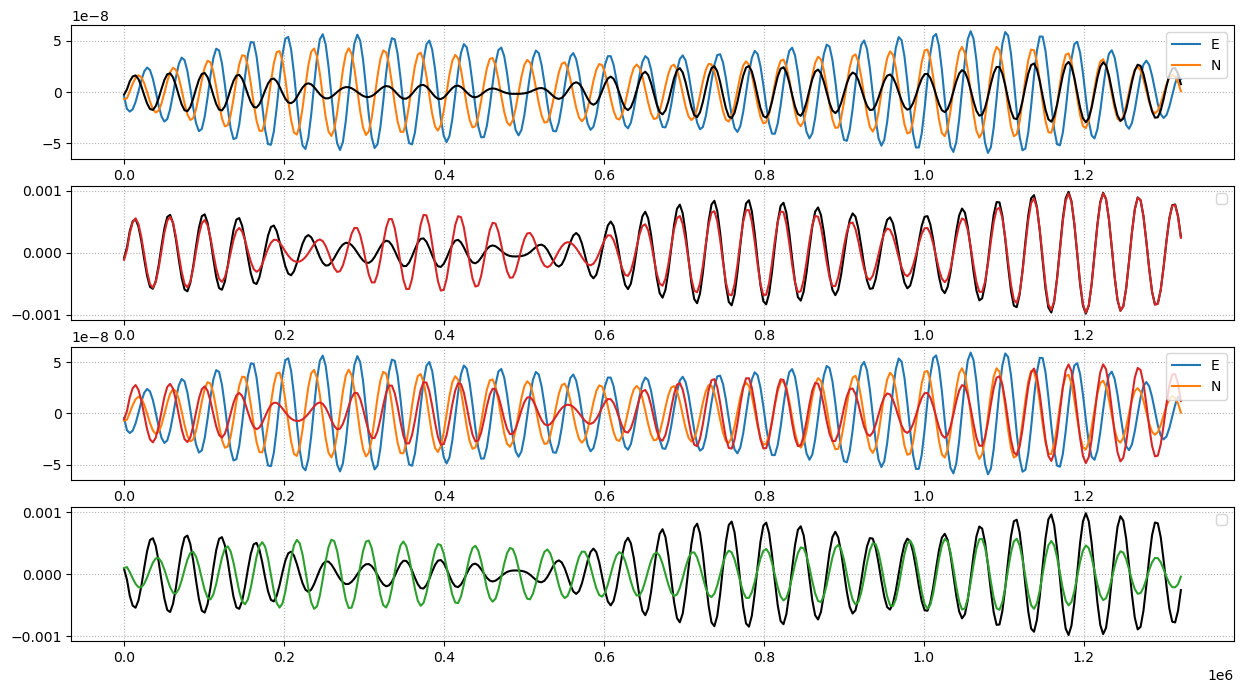

In [624]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(t0, dat0, label="E", color="tab:blue")
    ax[0].plot(t1, dat1, label="N", color="tab:orange")
    ax[0].plot(t2, dat2_mod, color="k")

    ax[1].plot(t2, dat2*-1, color="k")
    ax[1].plot(t2, res_p*-1, color="tab:red")

    ax[2].plot(t0, dat0, label="E", color="tab:blue")
    ax[2].plot(t1, dat1, label="N", color="tab:orange")
    ax[2].plot(t2, res_p*-5e-5, color="tab:red")

    ax[3].plot(t2, dat2, color="k")
    ax[3].plot(t2, mod, color="tab:green")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

fig = __makeplot();


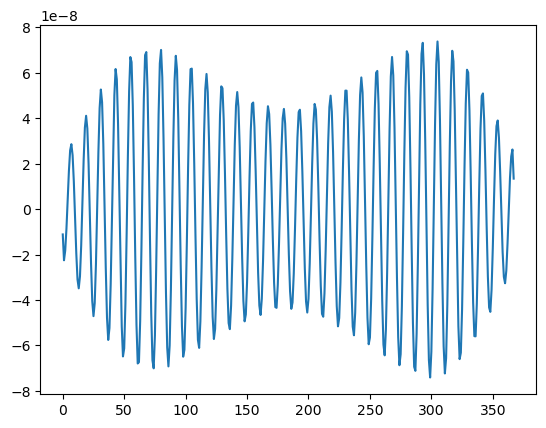

In [625]:
plt.plot(dat0+dat1)